In [1]:
import numpy as np
from keras.preprocessing.text import one_hot
def seqTrans(argument):
    switcher = {
        'A': 1,
        'T': 2,
        'G': 3,
        'C': 4,
        'N': np.random.randint(1,4)
    }
    return switcher.get(argument, "Invalid month")

def lineToArr(line):
    arr = np.array([])
    for a in line:
        v = seqTrans(a)    
        arr = np.append(arr,v)    
    return arr


import csv

l_arr = []
y =np.array([])

vocab_size = 64


with open('NGS201708_Censored(updated).csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            #print row
            line_count += 1
        else:            
            line_count += 1
            s = row[0]
            lw = [s[i:i+3] for i in range(0, len(s)-2, 1)]  #lw = [s[i:i+3] for i in range(0, len(s), 3)]            
            encoded_docs = [one_hot(d, vocab_size) for d in lw]
            arr_id = np.asarray(encoded_docs)            
            l_arr.append(arr_id.ravel())
            y = np.append(y,row[2])            
            
m_data = np.asmatrix(l_arr)
y = y.astype('float32')
#m_data = m_data.astype('float32')
#m_data = np.expand_dims(m_data, axis=2)
#m_data=m_data.transpose()
#y = y.reshape(1,len(y))
print y.shape, m_data.shape

/home/xsong/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(17938,) (17938, 31)


In [2]:
#  Equanlization of training dataset,get 70% of dataset as trainning dataset
Equalization = False
train_ratio = 0.7
if Equalization:
    id_1 =  np.where(y==1)
    id_1 = id_1[0] 
    k = id_1.tolist()
    idx = np.random.randint(len(k),size=int(len(k)*train_ratio))
    x_train = m_data[idx,]
    y_train = y[idx,]
    print x_train.shape,y_train.shape
else:
    # No equalization of training dataset    
    idx = np.random.randint(len(y), size=int(len(y)*train_ratio))
    x_train = m_data[idx,]
    y_train = y[idx,]
    print x_train.shape,y_train.shape
    
    
from keras.utils import to_categorical

num_classes = 2

x_train = x_train.astype(int)
y_train = to_categorical(y_train,num_classes)
print y_train.shape

(12556, 31) (12556,)
(12556, 2)


In [3]:
y_train.shape

(12556, 2)

In [4]:
from keras import backend as K
import tensorflow as tf
'''
Compatible with tensorflow backend
'''
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        	pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        	return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.utils import plot_model
#from focal_loss import focal_loss
model = Sequential()

vocab_size=64
max_length = 31
model.add(Embedding(vocab_size, 8 , input_length=max_length))
#model.add(Flatten())
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(512, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

#model.add(Dense(1, activation="linear"))
# compile the model 编译

model.compile(optimizer='adam', loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model 打印模型信息

print(model.summary())
plot_model(model,to_file='1dconv.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 8)             512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 128)           3200      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 256)           98560     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 9, 256)            196864    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 256)            0         
__________

In [10]:
# fit the model 拟合
import keras

BATCH_SIZE=200
EPOCHS = 50
print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

history = model.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.1,
                      verbose=1)
#history = model.fit(x_train, y_train, epochs=50,verbose=1)
# evaluate the model 评估
#loss, accuracy = model.evaluate(x_train, labels, verbose=0)
#print('Accuracy: %f' % (accuracy*100))


--- Fit the model ---

Train on 11300 samples, validate on 1256 samples
Epoch 1/50
11300/11300 [==============================] - 1s 86us/step - loss: 26.2923 - acc: 0.7470 - val_loss: 24.9927 - val_acc: 0.7492
Epoch 2/50
11300/11300 [==============================] - 1s 86us/step - loss: 22.2282 - acc: 0.8160 - val_loss: 20.8148 - val_acc: 0.8264
Epoch 3/50
11300/11300 [==============================] - 1s 84us/step - loss: 18.1307 - acc: 0.8578 - val_loss: 18.3000 - val_acc: 0.8559
Epoch 4/50
11300/11300 [==============================] - 1s 86us/step - loss: 15.3851 - acc: 0.8820 - val_loss: 19.8565 - val_acc: 0.8296
Epoch 5/50
11300/11300 [==============================] - 1s 82us/step - loss: 13.1773 - acc: 0.9023 - val_loss: 13.7927 - val_acc: 0.8917
Epoch 6/50
11300/11300 [==============================] - 1s 90us/step - loss: 10.9879 - acc: 0.9216 - val_loss: 14.1846 - val_acc: 0.8917
Epoch 7/50
11300/11300 [==============================] - 1s 86us/step - loss: 9.2872 - acc: 

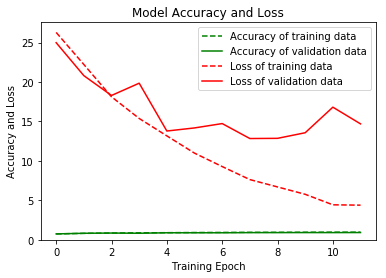

In [11]:
# summarize history for accuracy and loss
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [12]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


--- Check against test data ---

(8851, 31) (8851,)
8851/8851 [==============================] - 1s 84us/step

Accuracy on test data: 0.88

Loss on test data: 3.85

--- Confusion matrix for test data ---



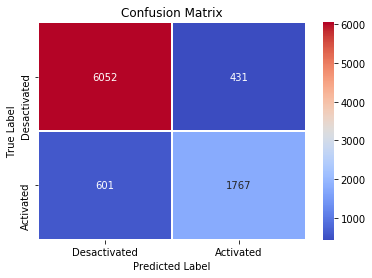


--- Classification report for test data ---

             precision    recall  f1-score   support

          0       0.91      0.93      0.92      6483
          1       0.80      0.75      0.77      2368

avg / total       0.88      0.88      0.88      8851



In [13]:
#%%
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
from scipy import stats
LABELS = ["Desactivated",
          "Activated"]

print("\n--- Check against test data ---\n")

x_test=np.delete(m_data,idx,axis=0)
y_test=np.delete(y,idx)
print x_test.shape, y_test.shape

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))